# Molecular basis of opioid receptor signaling
https://doi.org/10.1016/j.cell.2023.10.029

In [1]:
import os
import sys

# Get the current notebook's directory
current_directory = os.getcwd()

# Get the parent directory
parent_directory = os.path.dirname(os.path.dirname(current_directory))

# Add the parent directory to the module search path
sys.path.insert(0, parent_directory)
print(parent_directory)

/n/holylabs/LABS/mzitnik_lab/Users/afang/GET


In [2]:
from data.converter.pdb_to_list_blocks import pdb_to_list_blocks
from data.converter.sm_pdb_to_blocks import sm_pdb_to_blocks
from data.dataset import VOCAB
from data.dataset import blocks_interface, blocks_to_data
from data.dataset import BlockGeoAffDataset
import models
import torch
from trainers.abs_trainer import Trainer
import importlib
import matplotlib.pyplot as plt

/n/home13/afang/.conda/envs/interactenv1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
importlib.reload(models)
import models
import data.dataset
importlib.reload(data.dataset)
from data.dataset import blocks_interface

In [9]:
# pretrain_ckpt = "/n/holyscratch01/mzitnik_lab/afang/GET/datasets/LBA/split-by-sequence-identity-30/models/InteractNN/version_71/checkpoint/epoch66_step9045.ckpt"
pretrain_ckpt = "/n/holyscratch01/mzitnik_lab/afang/GET/datasets/LBA/split-by-sequence-identity-30/models/InteractNN/version_89/checkpoint/epoch69_step29470.ckpt" # finetuned from QBioLIP
# pretrain_ckpt = "/n/holyscratch01/mzitnik_lab/afang/GET/datasets/LBA/split-by-sequence-identity-30/models/InteractNN/version_86/checkpoint/epoch71_step30240.ckpt" # finetuned from QBioLIP
# pretrain_ckpt = "/n/holyscratch01/mzitnik_lab/afang/GET/datasets/LBA/split-by-sequence-identity-30/models/InteractNN/version_85/checkpoint/epoch73_step31228.ckpt" # finetuned from QBioLIP

# pretrain_ckpt = "/n/holyscratch01/mzitnik_lab/afang/GET/datasets/LBA/split-by-sequence-identity-30/models/InteractNN/version_88/checkpoint/epoch50_step21522.ckpt" # finetuned from CSD + QBioLIP
model = models.AffinityPredictor.load_from_pretrained(pretrain_ckpt)

/n/home13/afang/.conda/envs/interactenv1/lib/python3.9/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


In [10]:
receptor_file = "8ef5.pdb"
ligand_file = "8ef5_ligand_chM.pdb"
chain = "M"

In [11]:
raw_receptor_blocks = pdb_to_list_blocks(receptor_file, selected_chains=[chain])[0]
ligand = sm_pdb_to_blocks(ligand_file)
receptor_blocks, _, receptor_indexes, ligand_indexes = blocks_interface(raw_receptor_blocks, ligand, 8.0, return_indexes=True)
data = blocks_to_data(receptor_blocks, ligand)
data["label"] = -1

In [12]:
from Bio.PDB import PDBParser
from data.dataset import Block, Atom, VOCAB

receptor_pdb_indexes = []

pdb = receptor_file
selected_chains = [chain]

parser = PDBParser(QUIET=True)
structure = parser.get_structure('anonym', pdb)

list_blocks, chain_ids = [], {}

for chain in structure.get_chains():

    _id = chain.get_id()
    if (selected_chains is not None) and (_id not in selected_chains):
        continue

    residues, res_ids = [], {}

    for idx, residue in enumerate(chain):
        abrv = residue.get_resname()
        residx = residue.get_id()[1]
        if idx in receptor_indexes:
            receptor_pdb_indexes.append((idx, abrv, residx))
        hetero_flag, res_number, insert_code = residue.get_id()
        res_id = f'{res_number}-{insert_code}'
        if hetero_flag == 'W':
            continue   # residue from glucose (WAT) or water (HOH)
        if hetero_flag.strip() != '' and res_id in res_ids:
            continue  # the solution (e.g. H_EDO (EDO))
        if abrv == 'MSE':
            abrv = 'MET'  # MET is usually transformed to MSE for structural analysis
        symbol = VOCAB.abrv_to_symbol(abrv)
            
        # filter Hs because not all data include them
        atoms = [ Atom(atom.get_id(), atom.get_coord(), atom.element) for atom in residue if atom.element != 'H' ]
        residues.append(Block(symbol, atoms))
        res_ids[res_id] = True
    
#     # the last few residues might be non-relevant molecules in the solvent if their types are unk
#     end = len(residues) - 1
#     while end >= 0:
#         if residues[end].symbol == VOCAB.UNK:
#             end -= 1
#         else:
#             break
#     residues = residues[:end + 1]
#     if len(residues) == 0:  # not a chain
#         continue

#     chain_ids[_id] = len(list_blocks)
#     list_blocks.append(residues)

# # reorder
# if selected_chains is not None:
#     list_blocks = [list_blocks[chain_ids[chain_id]] for chain_id in selected_chains]

In [13]:
batch = BlockGeoAffDataset.collate_fn([data])
batch = Trainer.to_device(batch, "cuda:0")
model = model.to("cuda:0")
with torch.no_grad():
    binding_affinity, return_value = model.infer(batch, extra_info=True)
res = (binding_affinity, -return_value.block_energy) 
print("Prediction:", res[0])
print("Block level prediction:", res[1])

Prediction: tensor([5.8390], device='cuda:0')
Block level prediction: tensor([ 0.1248,  0.1224,  0.1303,  0.0245,  0.0786,  0.0847,  0.0217,  0.0533,
         0.0587,  0.0555,  0.1263,  0.0608,  0.0404,  0.2108,  0.1569,  0.0401,
         0.1044,  0.0177,  0.0796,  0.1426,  0.2138,  0.0594,  0.1098, -0.0144,
         0.0987,  0.0969, -0.0175,  0.0030,  0.0091,  0.0845,  0.0444,  0.1255,
         0.0501,  0.0524,  0.1433,  0.0217,  0.0327,  0.0092,  0.1248,  0.1275,
         0.0944,  0.0823,  0.1145,  0.1225,  0.1096,  0.1303,  0.1272,  0.0823,
         0.1082,  0.1105,  0.1293,  0.1053,  0.1062,  0.1483,  0.0914,  0.0730,
         0.1162,  0.1272,  0.0993,  0.1417,  0.1207,  0.1503,  0.1466,  0.0923],
       device='cuda:0')


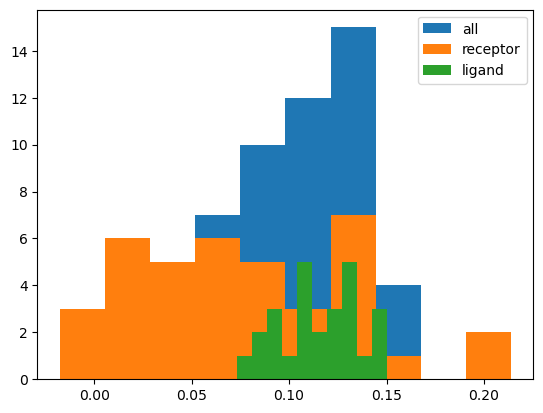

In [14]:
plt.hist(res[1].cpu().detach().numpy(), label="all")
plt.hist(res[1][batch["segment_ids"] == 0].cpu().detach().numpy(), label="receptor")
plt.hist(res[1][batch["segment_ids"] == 1].cpu().detach().numpy(), label="ligand")
plt.legend()
plt.show()

In [15]:
res_sorted, res_indexes = torch.sort(res[1], descending=True)
res_indexes

tensor([20, 13, 14, 61, 53, 62, 34, 19, 59, 45,  2, 50, 39, 57, 46, 10, 31,  0,
        38, 43,  1, 60, 56, 42, 49, 22, 44, 48, 52, 51, 16, 58, 24, 25, 40, 63,
        54,  5, 29, 41, 47, 18,  4, 55, 11, 21,  8,  9,  7, 33, 32, 30, 12, 15,
        36,  3,  6, 35, 17, 37, 28, 27, 23, 26], device='cuda:0')

In [16]:
res_sorted

tensor([ 0.2138,  0.2108,  0.1569,  0.1503,  0.1483,  0.1466,  0.1433,  0.1426,
         0.1417,  0.1303,  0.1303,  0.1293,  0.1275,  0.1272,  0.1272,  0.1263,
         0.1255,  0.1248,  0.1248,  0.1225,  0.1224,  0.1207,  0.1162,  0.1145,
         0.1105,  0.1098,  0.1096,  0.1082,  0.1062,  0.1053,  0.1044,  0.0993,
         0.0987,  0.0969,  0.0944,  0.0923,  0.0914,  0.0847,  0.0845,  0.0823,
         0.0823,  0.0796,  0.0786,  0.0730,  0.0608,  0.0594,  0.0587,  0.0555,
         0.0533,  0.0524,  0.0501,  0.0444,  0.0404,  0.0401,  0.0327,  0.0245,
         0.0217,  0.0217,  0.0177,  0.0092,  0.0091,  0.0030, -0.0144, -0.0175],
       device='cuda:0')

In [86]:
res_indexes[batch["segment_ids"][res_indexes] == 0]

tensor([13,  4, 31, 10,  1, 20, 22, 14, 25,  2, 19, 34, 21, 24, 18,  7, 29,  9,
         0, 16, 11, 32,  6,  5,  3, 17, 26, 28, 35, 15,  8, 12, 37, 33, 36, 23,
        27, 30], device='cuda:0')

In [87]:
receptor_res_indexes = res_indexes[batch["segment_ids"][res_indexes] == 0]
res_rec_sorted = res_sorted[batch["segment_ids"][res_indexes] == 0]
res_rec_sorted

tensor([ 0.2028,  0.1893,  0.1882,  0.1862,  0.1712,  0.1661,  0.1625,  0.1526,
         0.1470,  0.1462,  0.1449,  0.1360,  0.1293,  0.1269,  0.1225,  0.1217,
         0.1205,  0.1181,  0.0951,  0.0917,  0.0858,  0.0829,  0.0756,  0.0746,
         0.0695,  0.0689,  0.0661,  0.0639,  0.0464,  0.0458,  0.0391,  0.0357,
         0.0192,  0.0165,  0.0087,  0.0055, -0.0187, -0.0214], device='cuda:0',
       grad_fn=<IndexBackward0>)

### Highest contributing amino acids in receptor to binding affinity

In [88]:
print("Total receptor amino acids =", len(receptor_res_indexes))
for i, score in zip(receptor_res_indexes.cpu().detach()[:10], res_rec_sorted.cpu().detach()[:10]):
    if i == 0:
        print("global node")
    print(receptor_pdb_indexes[i-1], score)

Total receptor amino acids = 38
(83, 'ASP', 149) tensor(0.2028)
(60, 'GLN', 126) tensor(0.1893)
(258, 'ILE', 324) tensor(0.1882)
(80, 'ILE', 146) tensor(0.1862)
(56, 'THR', 122) tensor(0.1712)
(155, 'LEU', 221) tensor(0.1661)
(172, 'VAL', 238) tensor(0.1625)
(84, 'TYR', 150) tensor(0.1526)
(232, 'ILE', 298) tensor(0.1470)
(57, 'LEU', 123) tensor(0.1462)


In [20]:
segment_ids, lengths, block_lengths, A = batch["segment_ids"], batch["lengths"], batch["block_lengths"], batch["A"]
batch_id = torch.zeros_like(segment_ids)  # [Nb]
batch_id[torch.cumsum(lengths, dim=0)[:-1]] = 1
batch_id = batch_id.cumsum_(dim=0)  # [Nb], item idx in the batch

block_id = torch.zeros_like(A) # [Nu]
block_id[torch.cumsum(block_lengths, dim=0)[:-1]] = 1
block_id = block_id.cumsum_(dim=0)  # [Nu], block (residue) id of each unit (atom)

# Binding affinity predictions
The binding affinity of the ligands (higher binding affinity value $pK_d$ = more potent) to the receptors match the published order of potency: morphine < fentanyl < lofentanil
* Lofentanil
    * 7t2h: 7.4444
* Fentanyl
    * 8ef5_chR: 6.7673
    * 8ef5_chM: 6.7745
* Morphine
    * 8ef6_chM: 5.9950
    * 8ef6_chR: 5.9950

# Analysing 8ef5_chM-fentanyl interactions
Ordering the amino acids by their energy from highest to lowest shows which amino acids contribute the most to the binding affinity of fentanyl to the mu-opioid receptor. The top amino acids are:
* (1) ASP 149, chain M: it looks like the NH2 on asparagine interacts with the N in the fentanyl in the form of hydrogen bonding. This matches what is published here "in which the charged piperidine amine of fentanyl forms a salt bridge with Asp147 (note the two pdb files use diff numberings)" https://www.nature.com/articles/s41467-021-21262-9
* (2) MET 153, chain M: the sulfur interacts with the benzene - a favourable, stabilising methionine-aromatic interaction https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3471747/ 
* (3) TYR 328, chain M: **also identified in Cell review** - that fentanyl’s benzene ring engages in direct pi-pi interactions with the toggle switch residues W295 and Y328
* (10) **also identified in Cell review** W295 ranks 10th out of the 38 amino acids in the pocket


Questions to answer: how strongly does this correlate with minimum distance?

TODO: openeye visualisation of the binding pocket